In [1]:
# Student Performance Case Study (Udhaya Kumar K G)
# Notebook: student_performance_udhaya.ipynb

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, accuracy_score)
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

sns.set(style="whitegrid")
%matplotlib inline


In [2]:
# Update this path if needed
DATA_PATH = "../data/StudentsPerformance.csv"  # relative to notebooks/ folder
if not os.path.exists(DATA_PATH):
    # try alternative names (student-mat etc.)
    DATA_PATH = "/content/StudentsPerformance.csv"

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace('\ufeff', '') for c in df.columns]
print("Shape:", df.shape)
df.head()


Shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Basic info and stats
df.info()
df.describe(include='all').T
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,0
gender,0
race/ethnicity,0
parental level of education,0
lunch,0
test preparation course,0
math score,0
reading score,0
writing score,0


In [4]:
# If dataset has G1,G2,G3 (UCI):
if {'G1','G2','G3'}.issubset(set(df.columns)):
    df['average_score'] = df[['G1','G2','G3']].mean(axis=1)
    df['pass'] = (df['G3'] >= 10).astype(int)   # binary target
    target_col = 'pass'
else:
    # For Kaggle students-performance.csv (math score, reading score, writing score)
    if {'math score','reading score','writing score'}.issubset(set(df.columns)):
        df['average_score'] = df[['math score','reading score','writing score']].mean(axis=1)
        # create 4-level performance for example
        df['performance_level'] = pd.qcut(df['average_score'], 4, labels=['Poor','Average','Good','Excellent'])
        target_col = 'performance_level'
    else:
        raise ValueError("Unrecognized dataset: please check column names.")

# remove duplicates
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)


Duplicates: 0


In [5]:
# Numeric columns to check for outliers
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
# limit to useful numeric columns (drop engineered and target if present)
num_cols = [c for c in num_cols if c not in [target_col, 'average_score']]

def iqr_filter(df, cols):
    for c in cols:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        # show some info
        n_out = ((df[c] < lower) | (df[c] > upper)).sum()
        print(f"{c}: outliers={n_out}, range=({lower:.2f},{upper:.2f})")
        # Option: clip instead of drop
        df[c] = df[c].clip(lower, upper)
    return df

df = iqr_filter(df, [c for c in num_cols if c in df.columns])


math score: outliers=8, range=(27.00,107.00)
reading score: outliers=6, range=(29.00,109.00)
writing score: outliers=5, range=(25.88,110.88)


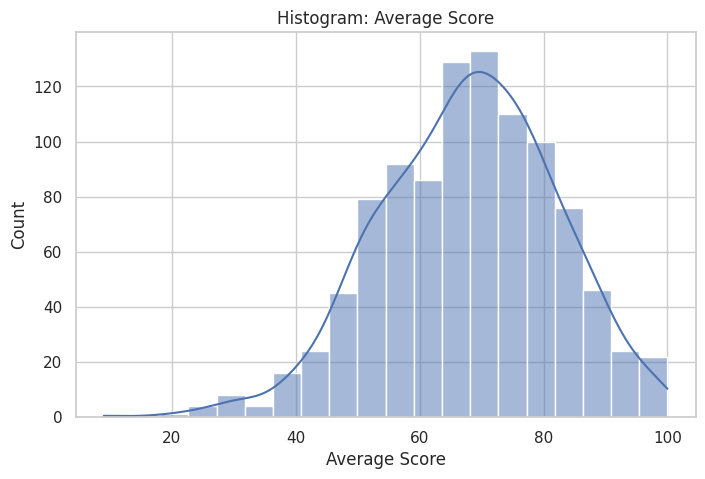

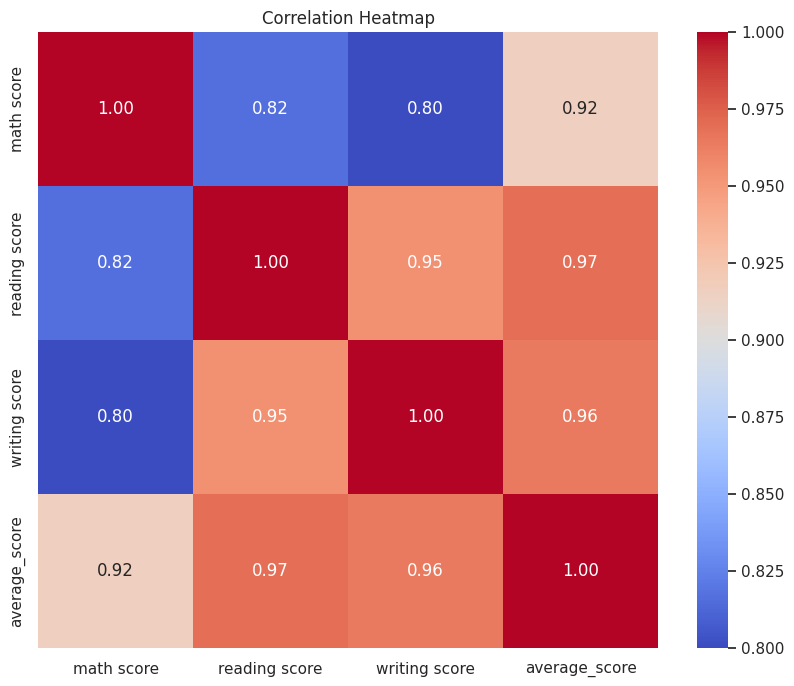

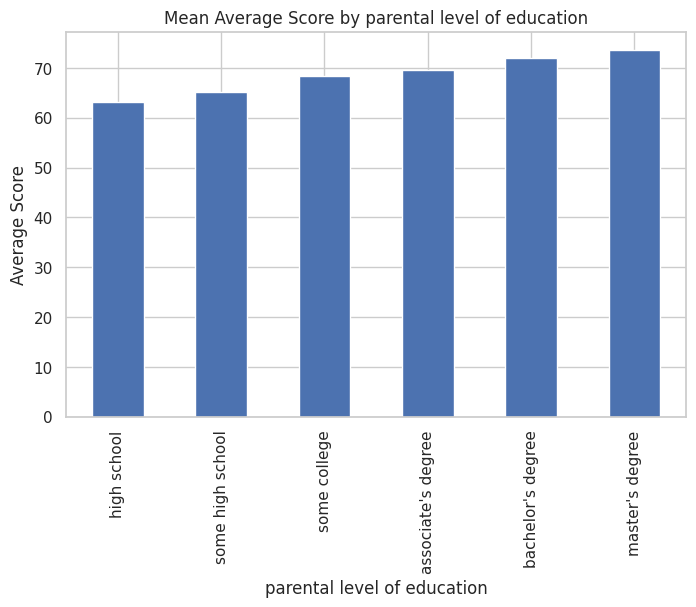

In [11]:
# create figures dir
fig_dir = "../figures"
os.makedirs(fig_dir, exist_ok=True)

# 1: Histogram of average_score / G3
plt.figure(figsize=(8,5))
sns.histplot(df['average_score'], bins=20, kde=True)
plt.title("Histogram: Average Score")
plt.xlabel("Average Score")
plt.savefig(os.path.join(fig_dir, "hist_average_score.png"), bbox_inches='tight')
plt.show()

# 2: Correlation heatmap (numeric features)
plt.figure(figsize=(10,8))
num_for_corr = df.select_dtypes(include=['int64','float64']).drop(columns=[target_col], errors='ignore')
corr = num_for_corr.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(fig_dir, "heatmap.png"), bbox_inches='tight')
plt.show()

# 3: Boxplot study time vs average score (if studytime exists)
if 'studytime' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='studytime', y='average_score', data=df)
    plt.title("Study Time vs Average Score")
    plt.savefig(os.path.join(fig_dir, "box_studytime_score.png"), bbox_inches='tight')
    plt.show()

# 4: Parental education vs mean grade (if present)
for col in ['parental level of education', 'Medu', 'Fedu']:
    if col in df.columns:
        plt.figure(figsize=(8,5))
        if df[col].dtype == 'O':  # categorical
            means = df.groupby(col)['average_score'].mean().sort_values()
            means.plot(kind='bar')
            plt.title(f"Mean Average Score by {col}")
            plt.ylabel("Average Score")
            plt.savefig(os.path.join(fig_dir, f"bar_{col.replace(' ','_')}.png"), bbox_inches='tight')
            plt.show()
        else:
            # numeric columns like Medu/Fedu: use boxplot
            sns.boxplot(x=df[col], y=df['average_score'])
            plt.title(f"{col} vs Average Score")
            plt.ylabel("Average Score")
            plt.savefig(os.path.join(fig_dir, f"box_{col.replace(' ','_')}.png"), bbox_inches='tight')
            plt.show()

# 5: Scatter absences vs average score
if 'absences' in df.columns:
    plt.figure(figsize=(8,5))
    sns.regplot(x='absences', y='average_score', data=df, scatter_kws={'s':10}, lowess=True)
    plt.title("Absences vs Average Score")
    plt.savefig(os.path.join(fig_dir, "scatter_absences_score.png"), bbox_inches='tight')
    plt.show()  # corrected

In [12]:
# identify features
exclude_cols = [target_col, 'average_score']
features = [c for c in df.columns if c not in exclude_cols]

# numeric and categorical separation
numeric_features = df[features].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = [c for c in features if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split data
X = df[features].copy()
y = df[target_col].copy()

# if classification & multiclass, label-encode y
if y.dtype == 'O' or str(y.dtype).startswith('category'):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
else:
    y_enc = y.values

X_train, X_temp, y_train, y_temp = train_test_split(X, y_enc, test_size=0.30, random_state=42, stratify=y_enc if len(np.unique(y_enc))>1 else None)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp if len(np.unique(y_temp))>1 else None)

# fit preprocessor on training set
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

print("Processed shapes:", X_train_proc.shape, X_val_proc.shape, X_test_proc.shape)


Numeric features: ['math score', 'reading score', 'writing score']
Categorical features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Processed shapes: (700, 20) (150, 20) (150, 20)


In [13]:
# RandomForest importance as proxy (only for classification / numeric y)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_proc, y_train)
importances = rf.feature_importances_

# mapping feature names: need to get names after onehot encoding
# get categorical feature names from the OneHotEncoder in the pipeline
ohe = None
for name, trans, cols in preprocessor.transformers_:
    if name == 'cat':
        ohe = trans.named_steps['onehot']
        cat_cols = cols
        break

# build feature names
num_names = numeric_features
cat_names = []
if ohe is not None:
    cat_enc_names = ohe.get_feature_names_out(categorical_features)
    cat_names = list(cat_enc_names)
all_feature_names = list(num_names) + cat_names

# show top 10 features
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
print("Top 10 features:\n", feat_imp.head(10))


Top 10 features:
 writing score                        0.315874
reading score                        0.288605
math score                           0.247876
gender_male                          0.015744
gender_female                        0.013729
lunch_free/reduced                   0.010019
lunch_standard                       0.009902
test preparation course_none         0.009801
race/ethnicity_group D               0.009354
test preparation course_completed    0.009261
dtype: float64


In [15]:
# Build model depending on task type (binary or multiclass)
n_inputs = X_train_proc.shape[1]
if len(np.unique(y_train)) <= 2:
    # binary classification
    model = keras.Sequential([
        layers.Input(shape=(n_inputs,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])
    y_train_fit = np.array(y_train)
    y_val_fit = np.array(y_val)
else:
    # multiclass
    num_classes = len(np.unique(y_train))
    model = keras.Sequential([
        layers.Input(shape=(n_inputs,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    y_train_fit = np.array(y_train)
    y_val_fit = np.array(y_val)

model.summary()

es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_proc, y_train_fit, validation_data=(X_val_proc, y_val_fit),
                    epochs=100, batch_size=32, callbacks=[es], verbose=1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,204 (43.77 KB)

 Trainable params: 11,204 (43.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.3734 - loss: 1.3570 - val_accuracy: 0.5667 - val_loss: 1.0001
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5582 - loss: 0.9936 - val_accuracy: 0.6933 - val_loss: 0.7448
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6626 - loss: 0.7640 - val_accuracy: 0.8533 - val_loss: 0.5621
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7685 - loss: 0.6122 - val_accuracy: 0.9133 - val_loss: 0.4220
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8380 - loss: 0.4715 - val_accuracy: 0.9133 - val_loss: 0.3263
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8385 - loss: 0.4245 - val_accuracy: 0.9400 - val_loss: 0.2651
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8710 - loss: 0.3619 - val_accuracy: 0.9533 - val_loss: 0.2298
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8805 - loss: 0.3243 - val_accuracy: 0.9533 -

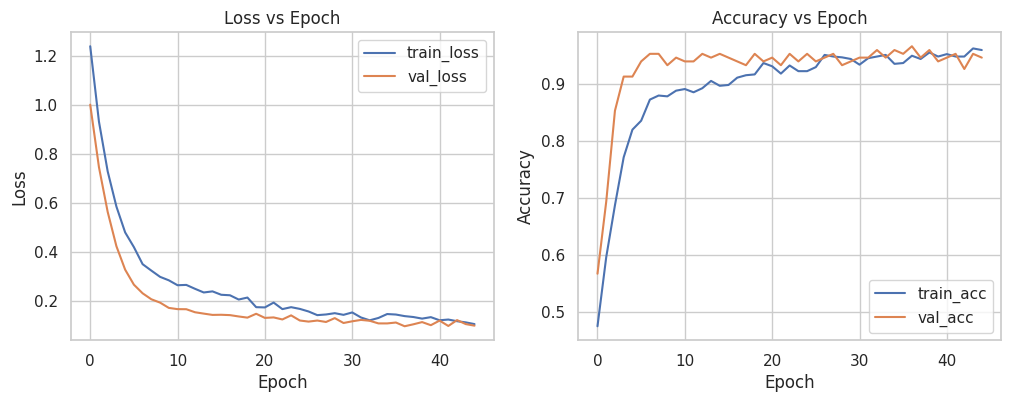

In [16]:
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss vs Epoch")

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy vs Epoch")
plt.savefig(os.path.join(fig_dir, "loss_accuracy_curves.png"), bbox_inches='tight')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Test Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.97      1.00      0.99        38
           2       0.92      0.95      0.93        37
           3       1.00      1.00      1.00        38

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



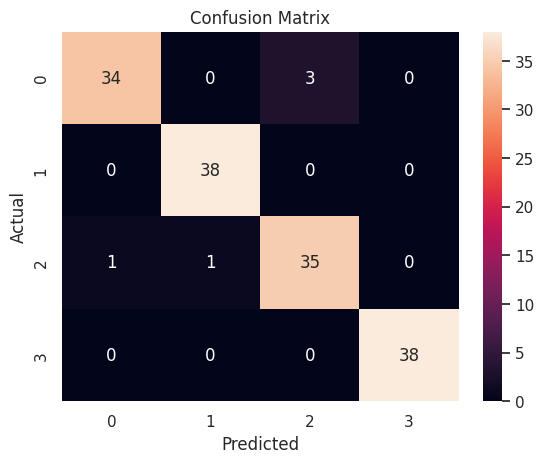

In [17]:
# predictions
if len(np.unique(y_train)) <= 2:
    y_proba = model.predict(X_test_proc).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.savefig(os.path.join(fig_dir, "confusion_matrix.png"), bbox_inches='tight')
    plt.show()

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
    plt.savefig(os.path.join(fig_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()
else:
    y_proba = model.predict(X_test_proc)
    y_pred = np.argmax(y_proba, axis=1)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.savefig(os.path.join(fig_dir, "confusion_matrix.png"), bbox_inches='tight')
    plt.show()


In [22]:
os.makedirs("/content/models", exist_ok=True)

# Save model in native Keras format
model.save("/content/models/student_mlp_model.keras")  # recommended over .h5

# Save preprocessor
joblib.dump(preprocessor, "/content/models/preprocessor.joblib")

print("Saved model and preprocessor to /content/models/")

Saved model and preprocessor to /content/models/


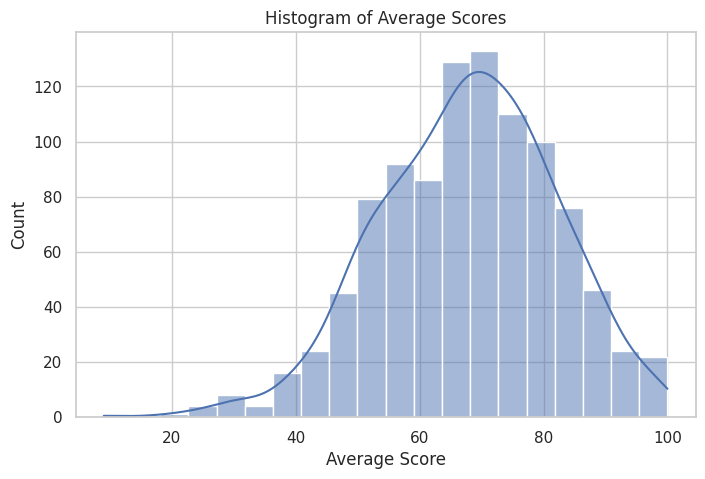

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(df['average_score'], bins=20, kde=True)  # replace 'G3' if your column has a different name
plt.title("Histogram of Average Scores")
plt.xlabel("Average Score")
plt.ylabel("Count")
plt.savefig(os.path.join(fig_dir, "hist_average_scores.png"), bbox_inches='tight')
plt.show()